# Time Alignment with micro-tcn

Work in progress for NASH Hackathon, Dec 17, 2021

this is like the 01_td_demo notebook only we use a different dataset and generalize the dataloader a bit

In [ ]:
#hide
#all_slow

## Installs and imports

In [ ]:
#show 
%pip install -Uqq pip 

# Next line only executes on Colab. Colab users: Please enable GPU in Edit > Notebook settings
! [ -e /content ] && pip install -Uqq fastai git+https://github.com/drscotthawley/fastproaudio.git

# Additional installs for this tutorial
%pip install -q fastai_minima torchsummary pyzenodo3 wandb

# Install micro-tcn and auraloss packages (from source, will take a little while)
%pip install -q wheel --ignore-requires-python git+https://github.com/csteinmetz1/micro-tcn.git  git+https://github.com/csteinmetz1/auraloss

# After this cell finishes, restart the kernel and continue below

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.callback.fp16 import *
import wandb
from fastai.callback.wandb import *
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.display import Audio 
import matplotlib.pyplot as plt
import torchsummary
from fastproaudio.core import *
from pathlib import Path
import glob
import json
import re 

## Dataset Generation Example -- See other file
Jacob's making the real dataset, but here's a brief intuitive demo of the strategy: paste a bunch of audio samples at regular intervals ("the grid") in a long array, then do another one where but randomly perturb the locations of the pastes.  Also there's a click track.

See the other document, ["Generating Dataset for Time Alignment Study"](https://drscotthawley.github.io/fastproaudio/ta_dataset_creation.html) for details on this. 


## Now Using the Real Dataset

We're going to use the multichannel version of the dataset.  And we're going to stick to 16kHz to keep everything small and fast for this hackathon. We can upgrade to 48kHz later. 

In [ ]:
path = Path('/home/shawley/Dropbox/Data/time_align/data/timeAlignData_mono2_mc/') # yea it's local, sorry

fnames_in = sorted(glob.glob(str(path)+'/*/input*'))
fnames_targ = sorted(glob.glob(str(path)+'/*/*targ*'))
ind = -1   # pick one spot in the list of files
fnames_in[ind], fnames_targ[ind]

('/home/shawley/Dropbox/Data/time_align/data/timeAlignData_mono2_mc/Val/input_133__1__60.wav',
 '/home/shawley/Dropbox/Data/time_align/data/timeAlignData_mono2_mc/Val/target_133__1__60.wav')

**Input audio**

Shape: (3, 64000), Dtype: torch.float32, Duration: 4.0 s
Max:  1.000,  Min: -0.937, Mean:  0.000, Std Dev:  0.089


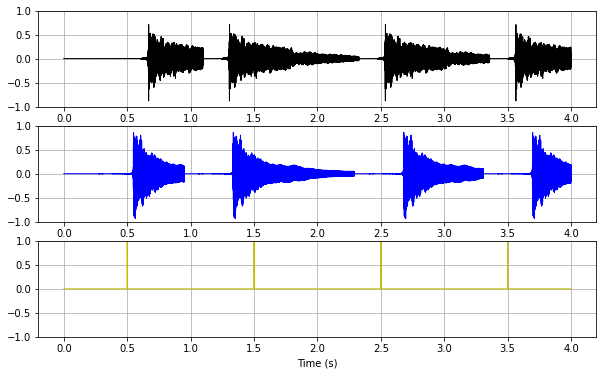

In [ ]:
waveform, sample_rate = torchaudio.load(fnames_in[ind])
show_audio(waveform, sample_rate)

**Target output audio**

Shape: (3, 64000), Dtype: torch.float32, Duration: 4.0 s
Max:  1.000,  Min: -0.937, Mean:  0.000, Std Dev:  0.091


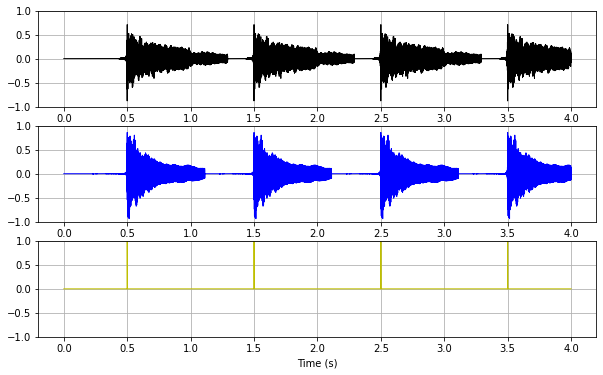

In [ ]:
target, sr_targ = torchaudio.load(fnames_targ[ind])
show_audio(target, sr_targ)

# Dataset class and Dataloaders
Here we modify Christian's SignalTrainLA2ADataset class from [micro-tcn](https://github.com/csteinmetz1/micro-tcn).  See his [data.py](https://github.com/csteinmetz1/micro-tcn/blob/main/microtcn/data.py)


We'll use original dataset class that Christian made, and then for fastai we'll "pack" params and inputs together.
(This will be loading multichannel wav files BTW)

In [ ]:
#from microtcn.data import SignalTrainLA2ADataset
# lets state it explicitly for debugging purposes 

class SignalTrainLA2ADataset(torch.utils.data.Dataset):
    """ SignalTrain LA2A dataset. Source: [10.5281/zenodo.3824876](https://zenodo.org/record/3824876)."""
    def __init__(self, root_dir, subset="train", length=16384, preload=False, half=True, fraction=1.0, use_soundfile=False):
        """
        Args:
            root_dir (str): Path to the root directory of the SignalTrain dataset.
            subset (str, optional): Pull data either from "train", "val", "test", or "full" subsets. (Default: "train")
            length (int, optional): Number of samples in the returned examples. (Default: 40)
            preload (bool, optional): Read in all data into RAM during init. (Default: False)
            half (bool, optional): Store the float32 audio as float16. (Default: True)
            fraction (float, optional): Fraction of the data to load from the subset. (Default: 1.0)
            use_soundfile (bool, optional): Use the soundfile library to load instead of torchaudio. (Default: False)
        """
        self.root_dir = root_dir
        self.subset = subset
        self.length = length
        self.preload = preload
        self.half = half
        self.fraction = fraction
        self.use_soundfile = use_soundfile

        if self.subset == "full":
            self.target_files = glob.glob(os.path.join(self.root_dir, "**", "target_*.wav"))
            self.input_files  = glob.glob(os.path.join(self.root_dir, "**", "input_*.wav"))
        else:
            # get all the target files files in the directory first
            self.target_files = glob.glob(os.path.join(self.root_dir, self.subset.capitalize(), "target_*.wav"))
            self.input_files  = glob.glob(os.path.join(self.root_dir, self.subset.capitalize(), "input_*.wav"))

        self.examples = [] 
        self.minutes = 0  # total number of hours of minutes in the subset

        # ensure that the sets are ordered correctlty
        self.target_files.sort()
        self.input_files.sort()

        # get the parameters 
        self.params = [(float(f.split("__")[1].replace(".wav","")), float(f.split("__")[2].replace(".wav",""))) for f in self.target_files]
        #print("self.params = ",self.params)
        
        # loop over files to count total length
        for idx, (tfile, ifile, params) in enumerate(zip(self.target_files, self.input_files, self.params)):

            ifile_id = int(os.path.basename(ifile).split("_")[1])
            tfile_id = int(os.path.basename(tfile).split("_")[1])
            if ifile_id != tfile_id:
                raise RuntimeError(f"Found non-matching file ids: {ifile_id} != {tfile_id}! Check dataset.")

            md = torchaudio.info(tfile)
            num_frames = md.num_frames

            if self.preload:
                sys.stdout.write(f"* Pre-loading... {idx+1:3d}/{len(self.target_files):3d} ...\r")
                sys.stdout.flush()
                input, sr  = self.load(ifile)
                target, sr = self.load(tfile)

                num_frames = int(np.min([input.shape[-1], target.shape[-1]]))
                if input.shape[-1] != target.shape[-1]:
                    print(os.path.basename(ifile), input.shape[-1], os.path.basename(tfile), target.shape[-1])
                    raise RuntimeError("Found potentially corrupt file!")
                if self.half:
                    input = input.half()
                    target = target.half()
            else:
                input = None
                target = None

            # create one entry for each patch
            self.file_examples = []
            #print("num_frames, self.length, num_frames // self.length = ",num_frames, self.length, num_frames // self.length)
            for n in range((num_frames // self.length)):
                offset = int(n * self.length)
                end = offset + self.length
                #print("idx, params = ",idx,params)
                self.file_examples.append({"idx": idx, 
                                           "target_file" : tfile,
                                           "input_file" : ifile,
                                           "input_audio" : input[:,offset:end] if input is not None else None,
                                           "target_audio" : target[:,offset:end] if input is not None else None,
                                           "params" : params,
                                           "offset": offset,
                                           "frames" : num_frames})

            # add to overall file examples
            self.examples += self.file_examples
        
        # use only a fraction of the subset data if applicable
        if self.subset == "train":
            classes = set([ex['params'] for ex in self.examples])
            print("classes = ",classes)
            n_classes = len(classes) # number of unique compressor configurations
            fraction_examples = int(len(self.examples) * self.fraction)
            n_examples_per_class = int(fraction_examples / n_classes)
            n_min_total = ((self.length * n_examples_per_class * n_classes) / md.sample_rate) / 60 
            n_min_per_class = ((self.length * n_examples_per_class) / md.sample_rate) / 60 
            print(sorted(classes))
            print(f"Total Examples: {len(self.examples)}     Total classes: {n_classes}")
            print(f"Fraction examples: {fraction_examples}    Examples/class: {n_examples_per_class}")
            print(f"Training with {n_min_per_class:0.2f} min per class    Total of {n_min_total:0.2f} min")

            if n_examples_per_class <= 0: 
                raise ValueError(f"Fraction `{self.fraction}` set too low. No examples selected.")

            sampled_examples = []

            for config_class in classes: # select N examples from each class
                class_examples = [ex for ex in self.examples if ex["params"] == config_class]
                example_indices = np.random.randint(0, high=len(class_examples), size=n_examples_per_class)
                class_examples = [class_examples[idx] for idx in example_indices]
                extra_factor = int(1/self.fraction)
                sampled_examples += class_examples * extra_factor

            self.examples = sampled_examples

        self.minutes = ((self.length * len(self.examples)) / md.sample_rate) / 60 

        # we then want to get the input files
        print(f"Located {len(self.examples)} examples totaling {self.minutes:0.2f} min in the {self.subset} subset.")

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        if self.preload:
            audio_idx = self.examples[idx]["idx"]
            offset = self.examples[idx]["offset"]
            input = self.examples[idx]["input_audio"]
            target = self.examples[idx]["target_audio"]
        else:
            offset = self.examples[idx]["offset"] 
            input, sr  = torchaudio.load(self.examples[idx]["input_file"], 
                                        num_frames=self.length, 
                                        frame_offset=offset, 
                                        normalize=False)
            target, sr = torchaudio.load(self.examples[idx]["target_file"], 
                                        num_frames=self.length, 
                                        frame_offset=offset, 
                                        normalize=False)
            if self.half:
                input = input.half()
                target = target.half()

        # at random with p=0.5 flip the phase 
        if np.random.rand() > 0.5:
            input *= -1
            target *= -1

        # then get the tuple of parameters
        params = torch.tensor(self.examples[idx]["params"]).unsqueeze(0)
        params[:,1] /= 100

        #print(f"Checking: idx = {idx}, input.shape = {input.shape}, target.shape = {target.shape}, params.shape = {params.shape}")
        
        return input, target, params

    def load(self, filename):
        if self.use_soundfile:
            x, sr = sf.read(filename, always_2d=True)
            x = torch.tensor(x.T)
        else:
            x, sr = torchaudio.load(filename, normalize=False)
        return x, sr
    
    
    
class SignalTrainLA2ADataset_fastai(SignalTrainLA2ADataset):
    "For fastai's sake, have getitem pack the inputs and params together"
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __getitem__(self, idx):
        input, target, params = super().__getitem__(idx)
        #print(f"Checking: idx = {idx}, input.shape = {input.shape}, params.shape = {params.shape}")
        if input.shape[0] > params.shape[0]:  # this is an artifact of our trying to pack things together
            #print("trying to fix...")
            params = torch.tile(params, (input.shape[0],1))
            #print(f"Checking2: idx = {idx}, input.shape = {input.shape}, params.shape = {params.shape}\n")
        return torch.cat((input,params),dim=-1), target   # pack input and params together

In [ ]:
class Args(object):  # stand-in for parseargs. these are all micro-tcn defaults
    model_type ='tcn'
    root_dir = str(path)
    preload = False
    sample_rate = 16000
    shuffle = True
    train_subset = 'train'
    val_subset = 'val'
    train_length = 32767
    train_fraction = 1.0
    eval_length = 32767
    batch_size = 8   # original is 32, my laptop needs smaller, esp. w/o half precision
    num_workers = 1  # 1 for debugging, 4 for normal usage 
    precision = 32  # LEAVE AS 32 FOR NOW: HALF PRECISION (16) NOT WORKING YET -SHH
    n_params = 2
    
args = Args()

#if args.precision == 16:  torch.set_default_dtype(torch.float16)

# setup the dataloaders
train_dataset = SignalTrainLA2ADataset_fastai(args.root_dir, 
                    subset=args.train_subset, 
                    fraction=args.train_fraction,
                    half=True if args.precision == 16 else False, 
                    preload=args.preload, 
                    length=args.train_length)

train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                    shuffle=args.shuffle,
                    batch_size=args.batch_size,
                    num_workers=args.num_workers,
                    pin_memory=True)

val_dataset = SignalTrainLA2ADataset_fastai(args.root_dir, 
                    preload=args.preload,
                    half=True if args.precision == 16 else False,
                    subset=args.val_subset,
                    length=args.eval_length)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                    shuffle=False,
                    batch_size=args.batch_size,
                    num_workers=args.num_workers,
                    pin_memory=True)

classes =  {(1.0, 60.0)}
[(1.0, 60.0)]
Total Examples: 104     Total classes: 1
Fraction examples: 104    Examples/class: 104
Training with 3.55 min per class    Total of 3.55 min
Located 104 examples totaling 3.55 min in the train subset.
Located 30 examples totaling 1.02 min in the val subset.


If the user requested fp16 precision then we need to install NVIDIA apex:

In [ ]:
if False and args.precision == 16:
    %pip install -q --disable-pip-version-check --no-cache-dir git+https://github.com/NVIDIA/apex
    from apex.fp16_utils import convert_network

### Define the model(s)
Christian defined a lot of models. We'll do the TCN-300 ~~and the LSTM~~. 

In [ ]:
#from microtcn.tcn_bare import TCNModel as TCNModel
#from microtcn.lstm import LSTMModel # actually the LSTM depends on a lot of Lightning stuff, so we'll skip that
from microtcn.utils import center_crop, causal_crop

class FiLM(torch.nn.Module):
    def __init__(self, 
                 num_features, 
                 cond_dim):
        super(FiLM, self).__init__()
        self.num_features = num_features
        self.bn = torch.nn.BatchNorm1d(num_features, affine=False)
        self.adaptor = torch.nn.Linear(cond_dim, num_features * 2)

    def forward(self, x, cond):

        cond = self.adaptor(cond)
        g, b = torch.chunk(cond, 2, dim=-1)
        g = g.permute(0,2,1)
        b = b.permute(0,2,1)

        x = self.bn(x)      # apply BatchNorm without affine
        x = (x * g) + b     # then apply conditional affine

        return x

class TCNBlock(torch.nn.Module):
    def __init__(self, 
                in_ch, 
                out_ch, 
                kernel_size=3, 
                padding=0, 
                dilation=1, 
                grouped=False, 
                conditional=False, 
                **kwargs):
        super(TCNBlock, self).__init__()

        self.in_ch = in_ch
        self.out_ch = out_ch
        self.kernel_size = kernel_size
        self.padding = padding
        self.dilation = dilation
        self.grouped = grouped
        self.conditional = conditional

        groups = out_ch if grouped and (in_ch % out_ch == 0) else 1
        
        #print(f"1 in_ch={in_ch} out_ch={out_ch} kernel_size={kernel_size} padding={padding} dilation={dilation} groups={groups}")
        self.conv1 = torch.nn.Conv1d(in_ch, 
                                     out_ch, 
                                     kernel_size=kernel_size, 
                                     padding=padding, 
                                     dilation=dilation,
                                     groups=groups,
                                     bias=False)
        #if grouped:
        #    self.conv1b = torch.nn.Conv1d(out_ch, out_ch, kernel_size=1)

        if conditional:
            self.film = FiLM(out_ch, 32)
        else:
            self.bn = torch.nn.BatchNorm1d(out_ch)

        self.relu = torch.nn.PReLU(out_ch)
        #print(f"2 in_ch={in_ch} out_ch={out_ch} kernel_size={kernel_size} padding={padding} dilation={dilation} groups={groups}")
        self.res = torch.nn.Conv1d(in_ch, 
                                   out_ch, 
                                   kernel_size=1,
                                   groups=in_ch,
                                   bias=False)

    def forward(self, x: torch.Tensor, p: torch.Tensor) -> torch.Tensor:
        x_in = x
        #print("TCNBlock.forward: x.shape = ",x.shape)
        
        x = self.conv1(x)
        #if self.grouped: # apply pointwise conv
        #    x = self.conv1b(x)
        if p is not None:   # apply FiLM conditioning
            x = self.film(x, p)
        else:
            x = self.bn(x)
        x = self.relu(x)

        x_res = self.res(x_in)
        x = x + center_crop(x_res, x.size(-1))

        return x

class TCNModel(torch.nn.Module):
    """ Temporal convolutional network with conditioning module.

        Args:
            nparams (int): Number of conditioning parameters.
            ninputs (int): Number of input channels (mono = 1, stereo 2). Default: 1
            noutputs (int): Number of output channels (mono = 1, stereo 2). Default: 1
            nblocks (int): Number of total TCN blocks. Default: 10
            kernel_size (int): Width of the convolutional kernels. Default: 3
            dialation_growth (int): Compute the dilation factor at each block as dilation_growth ** (n % stack_size). Default: 1
            channel_growth (int): Compute the output channels at each black as in_ch * channel_growth. Default: 2
            channel_width (int): When channel_growth = 1 all blocks use convolutions with this many channels. Default: 64
            stack_size (int): Number of blocks that constitute a single stack of blocks. Default: 10
            grouped (bool): Use grouped convolutions to reduce the total number of parameters. Default: False
            num_examples (int): Number of evaluation audio examples to log after each epochs. Default: 4
        """
    def __init__(self, 
                 nparams,
                 ninputs=1,
                 noutputs=1,
                 nblocks=10, 
                 kernel_size=3, 
                 dilation_growth=1, 
                 channel_growth=1, 
                 channel_width=32, 
                 stack_size=10,
                 grouped=False,
                 num_examples=4,
                 save_dir=None,
                 **kwargs):
        super(TCNModel, self).__init__()

        self.nparams=nparams
        self.ninputs=ninputs
        self.noutputs=noutputs
        self.nblocks=nblocks
        self.kernel_size=kernel_size
        self.dilation_growth=dilation_growth
        self.channel_growth=channel_growth
        self.channel_width=channel_width
        self.stack_size=stack_size
        self.grouped=grouped
        self.num_examples=num_examples
        self.save_dir=save_dir

        # setup loss functions
        self.l1      = torch.nn.L1Loss()

        print("nparams = ",nparams)
        if self.nparams > 0:
            self.gen = torch.nn.Sequential(
                torch.nn.Linear(nparams, 16),
                torch.nn.ReLU(),
                torch.nn.Linear(16, 32),
                torch.nn.ReLU(),
                torch.nn.Linear(32, 32),
                torch.nn.ReLU()
            )

        self.blocks = torch.nn.ModuleList()
        for n in range(nblocks):
            in_ch = out_ch if n > 0 else ninputs
            
            if self.channel_growth > 1:
                out_ch = in_ch * self.channel_growth 
            else:
                out_ch = self.channel_width

            dilation = self.dilation_growth ** (n % self.stack_size)
            #dilation = dilation_growth
            self.blocks.append(TCNBlock(in_ch, 
                                        out_ch, 
                                        kernel_size=self.kernel_size, 
                                        dilation=dilation,
                                        grouped=self.grouped,
                                        conditional=True if self.nparams > 0 else False))

        self.output = torch.nn.Conv1d(out_ch, noutputs, kernel_size=1)

    def forward(self, x, p=None):
        # if parameters present, 
        # compute global conditioning
        #print("TCNModel.forward: x.shape = ",x.shape)
        if p is not None:
            cond = self.gen(p)
        else:
            cond = None

        # iterate over blocks passing conditioning
        for idx, block in enumerate(self.blocks):
            x = block(x, cond)
            if idx == 0:
                skips = x
            else:
                skips = center_crop(skips, x.size(-1))
                skips = skips + x

        return torch.tanh(self.output(x + skips))

    def compute_receptive_field(self):
        """ Compute the receptive field in samples."""
        rf = self.kernel_size
        for n in range(1,self.nblocks):
            dilation = self.dilation_growth ** (n % self.stack_size)
            rf = rf + ((self.kernel_size-1) * dilation)
        return rf


In [ ]:

class TCNModel_fastai(TCNModel):
    "For fastai's sake, unpack the inputs and params"
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def forward(self, x, p=None):
        if (p is None) and (self.nparams > 0):  # unpack the params if needed
            assert len(list(x.size())) == 3   # sanity check 
            x, p = x[:,:,0:-self.nparams], x[:,:,-self.nparams:]
            #print("1 p.shape = ",p.shape)
            if p.shape[1] > 1:
                p = p[:,0:1,:]
                #print("2 p.shape = ",p.shape)
        return super().forward(x, p=p)

In [ ]:
#show
# micro-tcn defines several different model configurations. I just chose one of them. 
train_configs = [
      {"name" : "TCN-300",
     "model_type" : "tcn",
     "nblocks" : 10,
     "dilation_growth" : 2,
     "kernel_size" : 15,
     "causal" : False,
     "train_fraction" : 1.00,
     "batch_size" : args.batch_size
    }
]

dict_args = train_configs[0]
dict_args["channel_width"] = 33
dict_args["nparams"] = 2
dict_args["ninputs"] = 3  # number of input channels
dict_args["noutputs"] = 3  # number of output channels
dict_args["grouped"] = True # just making sure, b/c we're getting error about out_channels being devisible by groups. 

model = TCNModel_fastai(**dict_args)
dtype = torch.float32

nparams =  2


Let's take a look at the model:

In [ ]:
#show
# this summary allows one to compare the original TCNModel with the TCNModel_fastai
if type(model) == TCNModel_fastai:
    torchsummary.summary(model, [(3,args.train_length)], device="cpu")
else:
    torchsummary.summary(model, [(3,args.train_length),(1,2)], device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 16]              48
              ReLU-2                [-1, 1, 16]               0
            Linear-3                [-1, 1, 32]             544
              ReLU-4                [-1, 1, 32]               0
            Linear-5                [-1, 1, 32]           1,056
              ReLU-6                [-1, 1, 32]               0
            Conv1d-7            [-1, 33, 32751]           1,485
            Linear-8                [-1, 1, 66]           2,178
       BatchNorm1d-9            [-1, 33, 32751]               0
             FiLM-10            [-1, 33, 32751]               0
            PReLU-11            [-1, 33, 32751]              33
           Conv1d-12            [-1, 33, 32765]              33
         TCNBlock-13            [-1, 33, 32751]               0
           Conv1d-14            [-1, 33

### Getting the model into fastai form

Zach Mueller made a very helpful [fastai_minima](https://muellerzr.github.io/fastai_minima/) package that we'll use, and follow his instructions.  

> **TODO:** Zach says I should either use `fastai` or `fastai_minima`, not mix them like I'm about to do. But what I have below is the only thing that *works* right now. ;-) 

In [ ]:
#show
# I guess we could've imported these up at the top of the notebook...
from torch import optim
from fastai_minima.optimizer import OptimWrapper
#from fastai_minima.learner import Learner  # this doesn't include lr_find()
from fastai.learner import Learner
from fastai_minima.learner import DataLoaders
#from fastai_minima.callback.training_utils import CudaCallback, ProgressCallback # note sure if I need these

In [ ]:
def opt_func(params, **kwargs): return OptimWrapper(optim.SGD(params, **kwargs))

dls = DataLoaders(train_dataloader, val_dataloader)

### Checking Dataloaders

In [ ]:
if args.precision==16: 
    dtype = torch.float16
    model = convert_network(model, torch.float16)

model = model.to('cuda:0')
if type(model) == TCNModel_fastai:
    print("We're using Hawley's modified code")
    packed, targ = dls.one_batch()
    inp, params = packed[:,:,0:-dict_args['nparams']], packed[:,:,-dict_args['nparams']:]
    pred = model.forward(packed.to('cuda:0', dtype=dtype))
else:
    print("We're using Christian's version of Dataloader and model")
    inp, targ, params = dls.one_batch()
    pred = model.forward(inp.to('cuda:0',dtype=dtype), p=params.to('cuda:0', dtype=dtype))
print(f"input  = {inp.size()}\ntarget = {targ.size()}\nparams = {params.size()}\npred   = {pred.size()}")

We're using Hawley's modified code
input  = torch.Size([8, 3, 32767])
target = torch.Size([8, 3, 32767])
params = torch.Size([8, 3, 2])
pred   = torch.Size([8, 3, 18445])


We can make the pred and target the same length by cropping when we compute the loss:

In [ ]:
class Crop_Loss:
    "Crop target size to match preds"
    def __init__(self, axis=-1, causal=False, reduction="mean", func=nn.L1Loss):
        store_attr()
        self.loss_func = func()
    def __call__(self, pred, targ):
        targ = causal_crop(targ, pred.shape[-1]) if self.causal else center_crop(targ, pred.shape[-1])
        #pred, targ = TensorBase(pred), TensorBase(targ)
        assert pred.shape == targ.shape, f'pred.shape = {pred.shape} but targ.shape = {targ.shape}'
        return self.loss_func(pred,targ).flatten().mean() if self.reduction == "mean" else loss(pred,targ).flatten().sum()
    

# we could add a metric like MSE if we want
def crop_mse(pred, targ, causal=False): 
    targ = causal_crop(targ, pred.shape[-1]) if causal else center_crop(targ, pred.shape[-1])
    return ((pred - targ)**2).mean()

#### Enable logging with WandB:

In [ ]:
wandb.login()

wandb: Currently logged in as: drscotthawley (use `wandb login --relogin` to force relogin)


True

## Define the fastai Learner and callbacks

We're going to add a new custom WandBAudio callback futher below, that we'll uses when we call `fit()`.

#### WandBAudio Callback
In order to log audio samples, let's write our own audio-logging callback for fastai:

In [ ]:
class WandBAudio(Callback):
    """Progress-like callback: log audio to WandB"""
    order = ProgressCallback.order+1
    def __init__(self, n_preds=5, sample_rate=44100):
        store_attr()

    def after_epoch(self):  
        if not self.learn.training:
            with torch.no_grad():
                preds, targs = [x.detach().cpu().numpy().copy() for x in [self.learn.pred, self.learn.y]]
            log_dict = {}
            for i in range(min(self.n_preds, preds.shape[0])): # note wandb only supports mono
                    log_dict[f"preds_{i}"] = wandb.Audio(preds[i,0,:], caption=f"preds_{i}", sample_rate=self.sample_rate)
            wandb.log(log_dict)

#### Learner and wandb init

In [ ]:
wandb.init(project='time-align')#  no name, name=json.dumps(dict_args))

learn = Learner(dls, model, loss_func=Crop_Loss(), metrics=crop_mse, opt_func=opt_func,
               cbs= [WandbCallback()])

wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Train the model

We can use the fastai learning rate finder to suggest a learning rate:

/home/shawley/envs/fastai/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0012022644514217973)

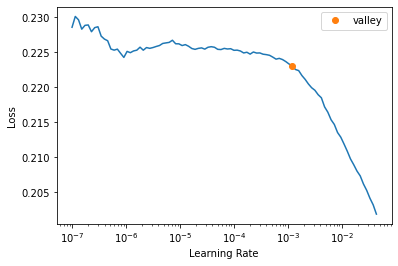

In [ ]:
learn.lr_find(end_lr=0.1) 

And now we'll train using the one-cycle LR schedule, with the WandBAudio callback. (Ignore any warning messages)

In [ ]:
epochs = 20  # change to 50 for better results but a longer wait
learn.fit_one_cycle(epochs, lr_max=3e-3, cbs=WandBAudio(sample_rate=args.sample_rate))

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'SignalTrainLA2ADataset_fastai' object has no attribute 'items'


epoch,train_loss,valid_loss,crop_mse,time
0,0.217239,0.106449,0.023609,00:01
1,0.197771,0.129669,0.028847,00:01
2,0.187676,0.079325,0.017791,00:01
3,0.173069,0.085064,0.018961,00:01
4,0.159723,0.085206,0.021149,00:01
5,0.148531,0.094621,0.024509,00:01
6,0.140252,0.109157,0.028412,00:01
7,0.133447,0.108512,0.028819,00:01
8,0.127395,0.108135,0.028720,00:01
9,0.121852,0.106104,0.027874,00:01


In [ ]:
wandb.finish() # call wandb.finish() after training or your logs may be incomplete

crop_mse,▅█▁▂▃▅███▇▇▆▆▅▅▅▅▅▅▅
dampening_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
nesterov_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,██▆▆▆▅▄▄▃▄▃▃▃▃▂▃▃▂▂▂▂▁▂▁▂▂▂▂▂▁▂▁▂▁▂▁▁▂▁▁
train_loss,██▇▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
valid_loss,▅█▁▂▂▃▅▅▅▅▄▄▄▃▃▃▃▃▃▃
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
crop_mse,0.02395


In [ ]:
learn.save('time_align')

Path('models/time_align.pth')

Go check out the resulting run logs, graphs, and audio samples at https://wandb.ai/drscotthawley/micro-tcn-fastai, or...
lemme see if I can embed some results below:

## TODO: Inference / Evaluation / Analysis

Load in the testing data

In [ ]:
test_dataset = SignalTrainLA2ADataset_fastai(args.root_dir, 
                    preload=args.preload,
                    half=True if args.precision == 16 else False,
                    subset='test',
                    length=args.eval_length)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                    shuffle=False,
                    batch_size=args.batch_size,
                    num_workers=args.num_workers,
                    pin_memory=True)

learn = Learner(dls, model, loss_func=Crop_Loss(), metrics=crop_mse, opt_func=opt_func, cbs=[])
learn.load('time_align')

Located 14 examples totaling 0.48 min in the test subset.


In [ ]:
!ls {path}/Test

input_134__1__60.wav  input_144__1__60.wav   target_140__1__60.wav
input_135__1__60.wav  input_145__1__60.wav   target_141__1__60.wav
input_136__1__60.wav  input_146__1__60.wav   target_142__1__60.wav
input_137__1__60.wav  input_147__1__60.wav   target_143__1__60.wav
input_138__1__60.wav  target_134__1__60.wav  target_144__1__60.wav
input_139__1__60.wav  target_135__1__60.wav  target_145__1__60.wav
input_140__1__60.wav  target_136__1__60.wav  target_146__1__60.wav
input_141__1__60.wav  target_137__1__60.wav  target_147__1__60.wav
input_142__1__60.wav  target_138__1__60.wav
input_143__1__60.wav  target_139__1__60.wav


Let's get some predictions from the model. Note that the length of these predictions will greater than in training, because we specified them differently:

In [ ]:
print(args.train_length, args.eval_length)

32767 32767


Handy routine to grab some data and run it through the model to get predictions:

In [ ]:
def get_pred_batch(dataloader, crop_target=True, causal=False):
    packed, target = next(iter(dataloader))
    input, params = packed[:,:,0:-dict_args['nparams']], packed[:,:,-dict_args['nparams']:]
    pred = model.forward(packed.to('cuda:0', dtype=dtype))
    if crop_target: target = causal_crop(target, pred.shape[-1]) if causal else center_crop(target, pred.shape[-1])
    input, params, target, pred = [x.detach().cpu() for x in [input, params, target, pred]]
    return input, params, target, pred

------- i = 0 ---------

input:
Shape: (3, 32767), Dtype: torch.float32, Duration: 2.0479375 s
Max:  1.000,  Min: -0.988, Mean:  0.000, Std Dev:  0.076


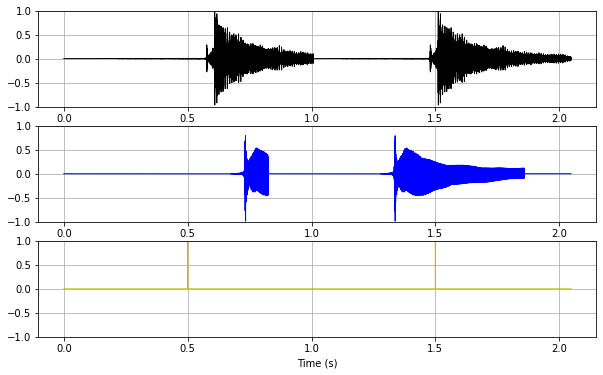

In [ ]:
input, params, target, pred = get_pred_batch(test_dataloader, causal=dict_args['causal'])
i = 0  # just look at the first element
print(f"------- i = {i} ---------\n")
print(f"input:")
show_audio(input[i], sample_rate)

prediction:
Shape: (3, 18445), Dtype: torch.float32, Duration: 1.1528125 s
Max:  0.361,  Min: -0.394, Mean:  0.003, Std Dev:  0.068


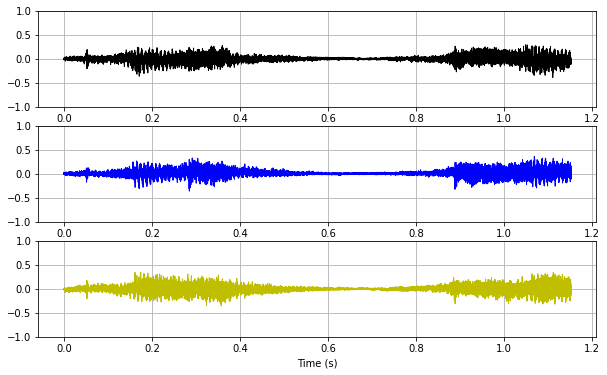

In [ ]:
print(f"prediction:")
show_audio(pred[i], sample_rate)

target:
Shape: (3, 18445), Dtype: torch.float32, Duration: 1.1528125 s
Max:  0.988,  Min: -1.000, Mean: -0.000, Std Dev:  0.096


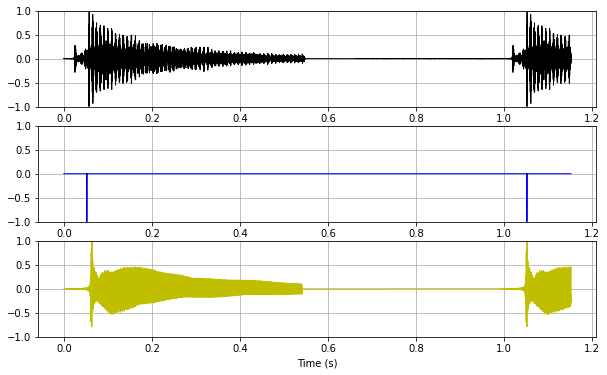

In [ ]:
print(f"target:")
show_audio(target[i], sample_rate)

## Deployment / Plugins

Check out [Christian's GitHub page for micro-tcn](https://github.com/csteinmetz1/micro-tcn#plugin) where he provides instructions and JUCE files by which to render the model as an audio plugin.  Pretty sure you can only do this with the causal models, which I didn't include -- yet! 

## Appendix

### Legacy code we're not using

In [ ]:
# keeping this class/code just for posterity but we're not gonna use it!  Skip this cell.
# any way to fold this? 
class MonoToMCDataset(torch.utils.data.Dataset):
    """
    UPDATE: turns out we're going to stick to Christian's original dataloader class and just use 
    conversion scripts to pack or unpack mono WAV files into multichannel WAV files.
    ----
    
    Modifying Steinmetz' micro-tcn code so we can load the kind of multichannel audio we want.
    The difference is that now, we group files that are similar except for a hyphen-designation, 
    e..g. input_235-1_.wav, input_235-2_.wav get read into one tensor.
    
    The 'trick' will be that we only ever store one filename 'version' of a group of files, but whenever we 
    want to try to load that file, we will also grab all its associated files. 
    
    Like SignalTrain LA2A dataset only more general"""
    def __init__(self, root_dir, subset="train", length=16384, preload=False, half=True, fraction=1.0, use_soundfile=False):
        """
        Args:
            root_dir (str): Path to the root directory of the SignalTrain dataset.
            subset (str, optional): Pull data either from "train", "val", "test", or "full" subsets. (Default: "train")
            length (int, optional): Number of samples in the returned examples. (Default: 40)
            preload (bool, optional): Read in all data into RAM during init. (Default: False)
            half (bool, optional): Store the float32 audio as float16. (Default: True)
            fraction (float, optional): Fraction of the data to load from the subset. (Default: 1.0)
            use_soundfile (bool, optional): Use the soundfile library to load instead of torchaudio. (Default: False)
        """
        self.root_dir = root_dir
        self.subset = subset
        self.length = length
        self.preload = preload
        self.half = half
        self.fraction = fraction
        self.use_soundfile = use_soundfile

        if self.subset == "full":
            self.target_files = glob.glob(os.path.join(self.root_dir, "**", "target_*.wav"))
            self.input_files  = glob.glob(os.path.join(self.root_dir, "**", "input_*.wav"))
        else:
            # get all the target files files in the directory first
            self.target_files = glob.glob(os.path.join(self.root_dir, self.subset.capitalize(), "target_*.wav"))
            self.input_files  = glob.glob(os.path.join(self.root_dir, self.subset.capitalize(), "input_*.wav"))

        self.examples = [] 
        self.minutes = 0  # total number of hours of minutes in the subset

        # ensure that the sets are ordered correctlty
        self.target_files.sort()
        self.input_files.sort()

        # get the parameters 
        self.params = [(float(f.split("__")[1].replace(".wav","")), float(f.split("__")[2].replace(".wav",""))) for f in self.target_files]

        
        # SHH: HERE is where we'll package similar hyphen-designated files together. list comprehension here wouldn't be good btw.
        # essentially we are removing 'duplicates'. the first file of each group will be the signifier of all of them
        self.target_files_all, self.input_files_all = self.target_files.copy(), self.input_files.copy() # save a copy of original list
        for x in self.target_files:  # remove extra accompanying tracks from main list that loader will use
            get_accompanying_tracks(x, self.target_files, remove=True)
        for x in self.input_files:
            get_accompanying_tracks(x, self.input_files, remove=True)
        # make a dict that will map main file name to list of accompanying files (including itself)
        self.target_accomp = {f: get_accompanying_tracks(f, self.target_files_all) for f in self.target_files}
        self.input_accomp = {f: get_accompanying_tracks(f, self.input_files_all) for f in self.input_files}
        
        # loop over files to count total length
        for idx, (tfile, ifile, params) in enumerate(zip(self.target_files, self.input_files, self.params)):

            ifile_id = int(os.path.basename(ifile).split("_")[1])
            tfile_id = int(os.path.basename(tfile).split("_")[1])
            if ifile_id != tfile_id:
                raise RuntimeError(f"Found non-matching file ids: {ifile_id} != {tfile_id}! Check dataset.")

            md = torchaudio.info(tfile)
            num_frames = md.num_frames

            if self.preload:
                sys.stdout.write(f"* Pre-loading... {idx+1:3d}/{len(self.target_files):3d} ...\r")
                sys.stdout.flush()
                
                input, sr  = self.load_accompanying(ifile, self.input_accomp)
                target, sr = self.load_accompanying(tfile, self.target_accomp)

                num_frames = int(np.min([input.shape[-1], target.shape[-1]]))
                if input.shape[-1] != target.shape[-1]:
                    print(os.path.basename(ifile), input.shape[-1], os.path.basename(tfile), target.shape[-1])
                    raise RuntimeError("Found potentially corrupt file!")
                if self.half:
                    input = input.half()
                    target = target.half()
            else:
                input = None
                target = None

            # create one entry for each patch
            self.file_examples = []
            for n in range((num_frames // self.length)):
                offset = int(n * self.length)
                end = offset + self.length
                self.file_examples.append({"idx": idx, 
                                           "target_file" : tfile,
                                           "input_file" : ifile,
                                           "input_audio" : input[:,offset:end] if input is not None else None,
                                           "target_audio" : target[:,offset:end] if input is not None else None,
                                           "params" : params,
                                           "offset": offset,
                                           "frames" : num_frames})

            # add to overall file examples
            self.examples += self.file_examples
        
        # use only a fraction of the subset data if applicable
        if self.subset == "train":
            classes = set([ex['params'] for ex in self.examples])
            n_classes = len(classes) # number of unique compressor configurations
            fraction_examples = int(len(self.examples) * self.fraction)
            n_examples_per_class = int(fraction_examples / n_classes)
            n_min_total = ((self.length * n_examples_per_class * n_classes) / md.sample_rate) / 60 
            n_min_per_class = ((self.length * n_examples_per_class) / md.sample_rate) / 60 
            print(sorted(classes))
            print(f"Total Examples: {len(self.examples)}     Total classes: {n_classes}")
            print(f"Fraction examples: {fraction_examples}    Examples/class: {n_examples_per_class}")
            print(f"Training with {n_min_per_class:0.2f} min per class    Total of {n_min_total:0.2f} min")

            if n_examples_per_class <= 0: 
                raise ValueError(f"Fraction `{self.fraction}` set too low. No examples selected.")

            sampled_examples = []

            for config_class in classes: # select N examples from each class
                class_examples = [ex for ex in self.examples if ex["params"] == config_class]
                example_indices = np.random.randint(0, high=len(class_examples), size=n_examples_per_class)
                class_examples = [class_examples[idx] for idx in example_indices]
                extra_factor = int(1/self.fraction)
                sampled_examples += class_examples * extra_factor

            self.examples = sampled_examples

        self.minutes = ((self.length * len(self.examples)) / md.sample_rate) / 60 

        # we then want to get the input files
        print(f"Located {len(self.examples)} examples totaling {self.minutes:0.2f} min in the {self.subset} subset.")

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        if self.preload:
            audio_idx = self.examples[idx]["idx"]
            offset = self.examples[idx]["offset"]
            input = self.examples[idx]["input_audio"]
            target = self.examples[idx]["target_audio"]
        else:
            offset = self.examples[idx]["offset"] 
            input_name = self.examples[idx]["input_file"]
            target_name = self.examples[idx]["target_file"]
            input = torch.empty((len(self.input_accomp[input_name]), self.length))
            for c, fname in enumerate(self.input_accomp[input_name]):
                input[c], sr  = torchaudio.load(fname, 
                                            num_frames=self.length, 
                                            frame_offset=offset, 
                                            normalize=False)
            target = torch.empty((len(self.target_accomp[target_name]), self.length))
            for c, fname in enumerate(self.target_accomp[target_name]):
                target[c], sr = torchaudio.load(fname, 
                                        num_frames=self.length, 
                                        frame_offset=offset, 
                                        normalize=False)
            if self.half:
                input = input.half()
                target = target.half()

        # at random with p=0.5 flip the phase 
        if np.random.rand() > 0.5:
            input *= -1
            target *= -1

        # then get the tuple of parameters
        params = torch.tensor(self.examples[idx]["params"]).unsqueeze(0)
        params[:,1] /= 100

        return input, target, params

    def load(self, filename):
        if self.use_soundfile:
            x, sr = sf.read(filename, always_2d=True)
            x = torch.tensor(x.T)
        else:
            x, sr = torchaudio.load(filename, normalize=False)
        return x, sr
    
    def load_accompanying(self, filename, accomp_dict):
        accomp = accomp_dict[filename]
        self.num_channels = len(accomp)
        md = torchaudio.info(filename)   # TODO:fix: assumes all accompanying tracks are the same shape, etc! 
        num_frames = md.num_frames
        data = torch.empty((self.num_channels,num_frames))
        for c, afile in enumerate(accomp):
            data[c], sr  = self.load(afile)
        return data, sr